<a href="https://colab.research.google.com/github/zaviruuu/Naga--ML-Based-Snake-Identifier-for-Sri-Lanka-/blob/input_validation_model/Input_Validation_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Input Validation Model


In [1]:
import os, shutil, random
from pathlib import Path
import numpy as np
import tensorflow as tf
from google.colab import drive

drive.mount('/content/drive')
print("TensorFlow:", tf.__version__)


Mounted at /content/drive
TensorFlow: 2.19.0


In [2]:
INPUT_DIR  = "/content/drive/MyDrive/DSGP_Group_32/NĀGA/Input Validation Model/Dataset"
OUTPUT_DIR = "/content/drive/MyDrive/DSGP_Group_32/NĀGA/Input Validation Model/Output"

IMG_SIZE = (224, 224)
BATCH = 32
SEED = 42

print("INPUT exists :", os.path.exists(INPUT_DIR))
print("valid exists :", os.path.exists(f"{INPUT_DIR}/valid"))
print("invalid exists:", os.path.exists(f"{INPUT_DIR}/invalid"))


INPUT exists : True
valid exists : False
invalid exists: False


In [3]:
from collections import Counter

def scan_exts(folder):
    exts = []
    for root, _, files in os.walk(folder):
        for f in files:
            exts.append(os.path.splitext(f)[1].lower())
    return Counter(exts)

print("Valid exts:", scan_exts(f"{INPUT_DIR}/Valid"))
print("Invalid exts:", scan_exts(f"{INPUT_DIR}/Invalid"))


Valid exts: Counter({'.jpg': 517})
Invalid exts: Counter({'.jpg': 494, '.png': 6})


In [4]:
from PIL import Image

random.seed(SEED)

CLASS_MAP = {
    "valid": "Valid",
    "invalid": "Invalid"
}

def make_clean_dir(path):
    path = Path(path)
    if path.exists():
        shutil.rmtree(path)
    path.mkdir(parents=True, exist_ok=True)

def list_all_images(folder):
    exts = {".jpg",".jpeg",".png",".webp",".bmp",".gif",".tif",".tiff"}
    return [p for p in Path(folder).rglob("*") if p.is_file() and p.suffix.lower() in exts]

def save_as_jpg(src, dst):
    img = Image.open(src).convert("RGB")
    img.save(dst, format="JPEG", quality=95)

def split_convert_and_save(train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-9

    make_clean_dir(OUTPUT_DIR)
    for sp in ["train","val","test"]:
        for cls in ["valid","invalid"]:
            (Path(OUTPUT_DIR)/sp/cls).mkdir(parents=True, exist_ok=True)

    for cls, real_folder in CLASS_MAP.items():
        src_cls = Path(INPUT_DIR) / real_folder
        if not src_cls.exists():
            raise FileNotFoundError(f"Missing folder: {src_cls}")

        files = list_all_images(src_cls)
        if len(files) == 0:
            raise ValueError(f"No images found in: {src_cls}")

        random.shuffle(files)
        n = len(files)
        n_train = int(n * train_ratio)
        n_val   = int(n * val_ratio)

        splits = {
            "train": files[:n_train],
            "val":   files[n_train:n_train+n_val],
            "test":  files[n_train+n_val:]
        }

        for sp, flist in splits.items():
            dst_dir = Path(OUTPUT_DIR) / sp / cls
            for f in flist:
                out = dst_dir / f"{f.stem}.jpg"
                if out.exists():
                    out = dst_dir / f"{f.stem}_{random.randint(1000,9999)}.jpg"
                try:
                    save_as_jpg(f, out)
                except Exception as e:
                    print("Skipping unreadable:", f, "|", e)

        print(f" {cls.upper()} -> total:{n} train:{len(splits['train'])} val:{len(splits['val'])} test:{len(splits['test'])}")

split_convert_and_save()
print(" Output saved to:", OUTPUT_DIR)


 VALID -> total:517 train:361 val:77 test:79
 INVALID -> total:500 train:350 val:75 test:75
 Output saved to: /content/drive/MyDrive/DSGP_Group_32/NĀGA/Input Validation Model/Output


In [5]:
def count_files(p):
    c = 0
    for _, _, files in os.walk(p):
        c += len(files)
    return c

for sp in ["train","val","test"]:
    for cls in ["valid","invalid"]:
        p = f"{OUTPUT_DIR}/{sp}/{cls}"
        print(sp, cls, "files =", count_files(p))


train valid files = 361
train invalid files = 350
val valid files = 77
val invalid files = 75
test valid files = 79
test invalid files = 75


###Load datasets

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = tf.keras.utils.image_dataset_from_directory(
    f"{OUTPUT_DIR}/train",
    label_mode="binary",
    image_size=IMG_SIZE,
    batch_size=BATCH,
    shuffle=True,
    seed=SEED
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    f"{OUTPUT_DIR}/val",
    label_mode="binary",
    image_size=IMG_SIZE,
    batch_size=BATCH,
    shuffle=False
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    f"{OUTPUT_DIR}/test",
    label_mode="binary",
    image_size=IMG_SIZE,
    batch_size=BATCH,
    shuffle=False
)


Found 711 files belonging to 2 classes.
Found 152 files belonging to 2 classes.
Found 154 files belonging to 2 classes.


###Preprocess

In [7]:
data_aug = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.05),
    tf.keras.layers.RandomZoom(0.1),
])

def prep_train(x,y):
    x = tf.cast(x, tf.float32)/255.0
    x = data_aug(x, training=True)
    return x,y

def prep_eval(x,y):
    x = tf.cast(x, tf.float32)/255.0
    return x,y

train_ds = train_ds.map(prep_train, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
val_ds   = val_ds.map(prep_eval,  num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
test_ds  = test_ds.map(prep_eval, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)


###Train model

In [8]:
base = tf.keras.applications.MobileNetV2(
    input_shape=(224,224,3),
    include_top=False,
    weights="imagenet"
)
base.trainable = False

model = tf.keras.Sequential([
    base,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint("best_validity_model.keras", save_best_only=True)
]

model.fit(train_ds, validation_data=val_ds, epochs=15, callbacks=callbacks)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.5757 - auc: 0.5910 - loss: 0.7198 - val_accuracy: 0.7500 - val_auc: 0.7791 - val_loss: 0.5648
Epoch 2/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.7025 - auc: 0.7705 - loss: 0.5749 - val_accuracy: 0.7697 - val_auc: 0.8267 - val_loss: 0.5115
Epoch 3/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.7381 - auc: 0.8285 - loss: 0.5137 - val_accuracy: 0.7763 - val_auc: 0.8492 - val_loss: 0.4784
Epoch 4/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.7698 - auc: 0.8465 - loss: 0.4807 - val_accuracy: 0.7895 - val_auc: 0.8672 - val_loss: 0.4494
Epoch 5/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.8018 - auc: 0.8913 - loss: 0.4156 - val_accuracy: 0.8289 - val_auc: 0.8820 - val_loss: 0.4268
Epoch 6/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.8114 - auc: 0.8818 - loss: 0.4282 - val_accuracy: 0.8289 - val_auc: 0.8898 - val_loss: 0.4189
Epo

In [9]:
test_loss, test_acc, test_auc = model.evaluate(test_ds)
print("Test Acc:", test_acc, "| Test AUC:", test_auc)

SAVE_PATH = "/content/drive/MyDrive/DSGP_Group_32/NĀGA/Input Validation Model/valid_invalid_model.keras"
model.save(SAVE_PATH)
print(" Saved:", SAVE_PATH)


5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.7823 - auc: 0.6091 - loss: 0.4370
Test Acc: 0.8311688303947449 | Test AUC: 0.9054852724075317
 Saved: /content/drive/MyDrive/DSGP_Group_32/NĀGA/Input Validation Model/valid_invalid_model.keras


In [10]:
import numpy as np

# 1) Get prediction probabilities
probs = model.predict(test_ds).ravel()

# 2) Convert probabilities to class labels (0/1)
preds = (probs >= 0.5).astype(int)

# 3) Get true labels from test dataset
y_true = np.concatenate(
    [y.numpy().astype(int).ravel() for _, y in test_ds],
    axis=0
)

print("y_true length:", len(y_true))
print("preds length :", len(preds))


5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step
y_true length: 154
preds length : 154


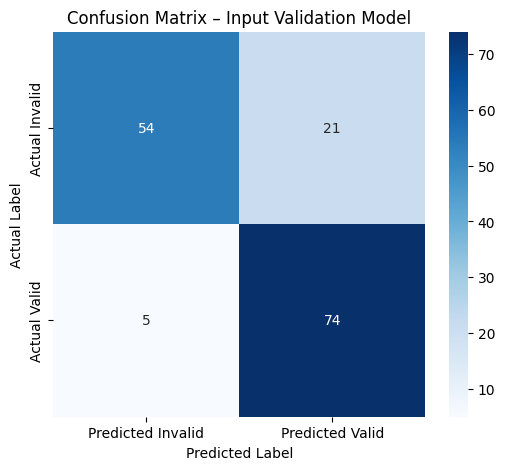

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_true, preds)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Predicted Invalid", "Predicted Valid"],
    yticklabels=["Actual Invalid", "Actual Valid"]
)
plt.title("Confusion Matrix – Input Validation Model")
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.show()


#####ROC Curve

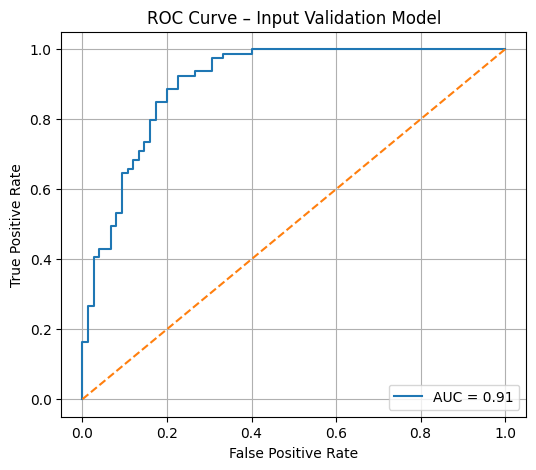

In [12]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_true, probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Input Validation Model")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


#####Threshold vs Errors

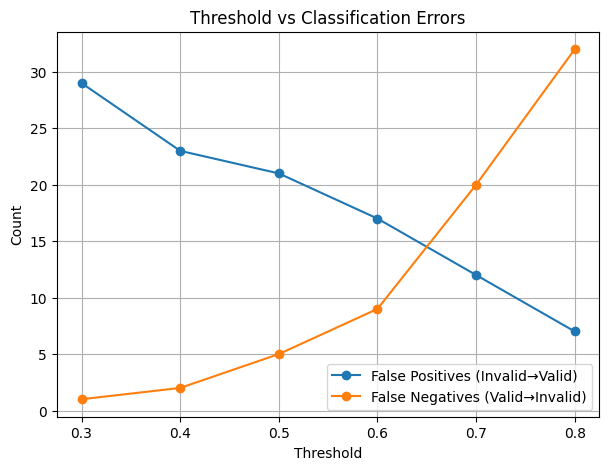

In [13]:
thresholds = [0.3,0.4,0.5,0.6,0.7,0.8]
fp_list, fn_list = [], []

for th in thresholds:
    p = (probs >= th).astype(int)
    cm = confusion_matrix(y_true, p)
    fp_list.append(cm[0,1])  # invalid → valid
    fn_list.append(cm[1,0])  # valid → invalid

plt.figure(figsize=(7,5))
plt.plot(thresholds, fp_list, marker='o', label="False Positives (Invalid→Valid)")
plt.plot(thresholds, fn_list, marker='o', label="False Negatives (Valid→Invalid)")
plt.xlabel("Threshold")
plt.ylabel("Count")
plt.title("Threshold vs Classification Errors")
plt.legend()
plt.grid(True)
plt.show()
